In [1]:
import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir("../..")
os.environ['NUMEXPR_NUM_THREADS'] = '10'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("ggplot")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

2024-02-08 02:58:55.830712: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-08 02:58:55.972337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 02:58:55.972391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 02:58:55.992564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 02:58:56.034355: I tensorflow/core/platform/cpu_feature_guar

In [7]:
from pathlib import Path

for i in Path("results/datasets_statistics").iterdir():
    print(i)

results/datasets_statistics/statistics_filtered.pcl
results/datasets_statistics/correlations.pdf
results/datasets_statistics/feature_values_plot.pdf
results/datasets_statistics/statistics_wo_cold_iu.pcl
results/datasets_statistics/Datafeatures_and_metrics.csv
results/datasets_statistics/statistics_df.csv
results/datasets_statistics/statistics.pcl
results/datasets_statistics/feature_importance_plot.pdf
results/datasets_statistics/statistics_raw.pcl


In [3]:
def find_optimal_silhouette(silhouette_scores):
    """Find the optimal number of clusters based on the maximum silhouette score."""
    optimal_clusters = (np.argmax(silhouette_scores) + 2)  # +2 because silhouette starts from 2 clusters
    return optimal_clusters


def find_optimal_davies_bouldin(db_scores):
    """Find the optimal number of clusters based on the minimum Davies-Bouldin score."""
    optimal_clusters = (np.argmin(db_scores) + 2)  # +2 because Davies-Bouldin starts from 2 clusters
    return optimal_clusters


def scale_data(data):
    """Scale the dataset."""
    scaler = StandardScaler()
    return scaler.fit_transform(data)


def fit_kmeans(data_scaled, n_clusters, random_state=0):
    """Fit KMeans and return the model."""
    kmeans = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        max_iter=300,
        n_init=10,
        random_state=random_state,
    )
    kmeans.fit(data_scaled)
    return kmeans


def evaluate_clustering(data_scaled, max_clusters, random_states=[0]):
    """Evaluate clustering using WCSS, silhouette scores, and Davies-Bouldin scores, across multiple random states."""
    wcss = np.zeros(max_clusters)
    silhouette_scores = np.zeros(
        max_clusters - 1
    )  # Silhouette scores start from 2 clusters
    db_scores = np.zeros(max_clusters - 1)  # Same for Davies-Bouldin scores

    for random_state in random_states:
        for i in range(1, max_clusters + 1):
            kmeans = fit_kmeans(data_scaled, i, random_state)
            wcss[i - 1] += kmeans.inertia_

            if (
                i > 1
            ):  # Silhouette and Davies-Bouldin scores require at least 2 clusters
                silhouette_scores[i - 2] += silhouette_score(
                    data_scaled, kmeans.labels_
                )
                db_scores[i - 2] += davies_bouldin_score(data_scaled, kmeans.labels_)

    # Average the scores over all random states
    wcss /= len(random_states)
    silhouette_scores /= len(random_states)
    db_scores /= len(random_states)

    return wcss.tolist(), silhouette_scores.tolist(), db_scores.tolist()


def plot_metric(values, metric_name, start=1, ylabel=""):
    """Plot the given metric with enhanced visual representation."""
    sns.set(style="whitegrid")  # Set the seaborn style for better visuals
    plt.figure(figsize=(6, 4))
    plt.plot(
        range(start, len(values) + start),
        values,
        marker="o",
        linestyle="-",
        color="royalblue",
    )
    plt.title(f"Evaluation of Clustering: {metric_name}", fontsize=16)
    plt.xlabel("Number of Clusters", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(
        range(start, len(values) + start)
    )  # Ensure every cluster number is marked
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()  # Adjust layout to not cut off labels/titles
    plt.show()


def fit_kmeans_and_return_cluster_dfs(data_scaled, n_clusters, random_state=1222):
    """Fit KMeans for n_clusters and return DataFrames for each cluster and their centroids."""
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", max_iter=1000, n_init=5, random_state=random_state)
    kmeans.fit(data_scaled)

    centroids = pd.DataFrame(kmeans.cluster_centers_, columns=data_scaled.columns)
    labels = kmeans.labels_

    cluster_dfs = {}
    for i in range(n_clusters):
        # Selecting rows that belong to the current cluster
        cluster_indices = data_scaled.index[labels == i]
        cluster_dfs[i] = data.loc[cluster_indices]

    return cluster_dfs, centroids, labels

In [8]:
data = pd.read_csv(Path("results/datasets_statistics/statistics_df.csv"), index_col=0)

In [9]:
data.keys()

Index(['Nu', 'Ni', 'Nr', 'SpaceSize', 'Shape', 'Density', 'Rpu', 'Rpi',
       'Ginii', 'Giniu', 'APB', 'StPB', 'SkPB', 'KuPB', 'LTavg', 'LTstd',
       'LTsk', 'LTku'],
      dtype='object')

In [11]:
data_scaled = pd.DataFrame(
    StandardScaler().fit_transform(data), data.index, data.columns
)
data_normalized = pd.DataFrame(
    MinMaxScaler().fit_transform(data), data.index, data.columns
)

### Raw DATA ###

Optimal number of clusters by Silhouette Method: 4
Optimal number of clusters by Davies-Bouldin Method: 8


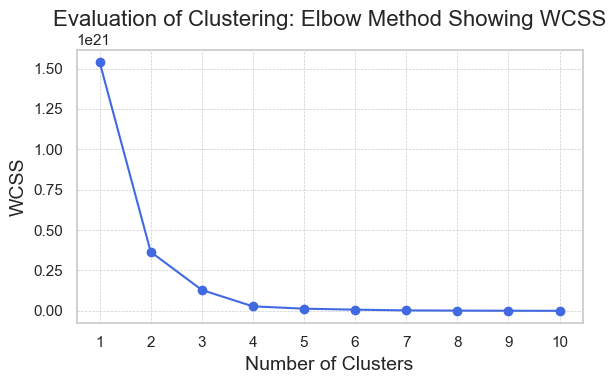

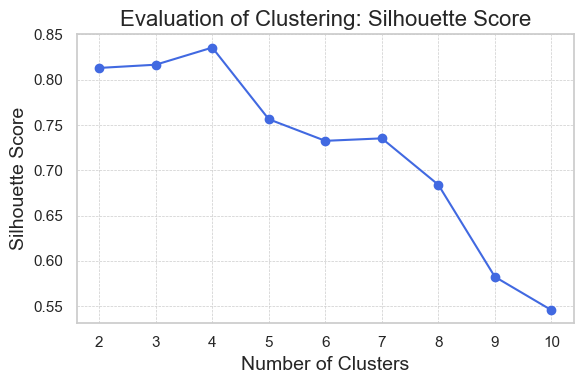

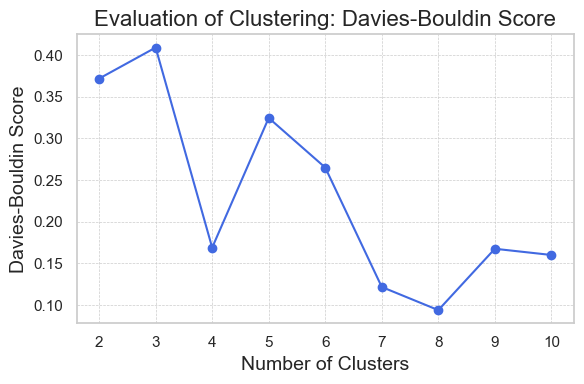

In [12]:
random_states = np.random.randint(0, 1000000, 100)

wcss, silhouette_scores, db_scores = evaluate_clustering(data, 10, random_states)
optimal_clusters_silhouette = find_optimal_silhouette(silhouette_scores)
optimal_clusters_davies_bouldin = find_optimal_davies_bouldin(db_scores)

print(f"Optimal number of clusters by Silhouette Method: {optimal_clusters_silhouette}")
print(
    f"Optimal number of clusters by Davies-Bouldin Method: {optimal_clusters_davies_bouldin}"
)
plot_metric(wcss, "Elbow Method Showing WCSS", ylabel="WCSS")
plot_metric(silhouette_scores, "Silhouette Score", start=2, ylabel="Silhouette Score")
plot_metric(db_scores, "Davies-Bouldin Score", start=2, ylabel="Davies-Bouldin Score")

In [13]:
n_optimal_clusters = 4

cluster_dfs, centroids, labels = fit_kmeans_and_return_cluster_dfs(
    data, n_optimal_clusters, random_state=1234
)

for i in range(len(cluster_dfs)):
    print(f"Cluster {i + 1} includes dataset: {cluster_dfs[i].index.tolist()}")

Cluster 1 includes dataset: ['yelp', 'sber_zvuk']
Cluster 2 includes dataset: ['amazon_mi', 'movielens_1m', 'rekko', 'douban_music', 'dianping', 'food', 'amazon_tv', 'reddit', 'movielens_20m', 'beeradvocate', 'tafeng', 'amazon_finefoods', 'brightkite', 'kuairec_full', 'retail', 'mts_library', 'movielens_10m', 'kuairec_small', 'epinions', 'douban_books', 'douban_movies', 'ratebeer', 'foursquare']
Cluster 3 includes dataset: ['amazon_cds', 'goodreads', 'gowalla', 'netflix']
Cluster 4 includes dataset: ['sber_smm']


### Normalized DATA ###

Optimal number of clusters by Silhouette Method: 3
Optimal number of clusters by Davies-Bouldin Method: 10


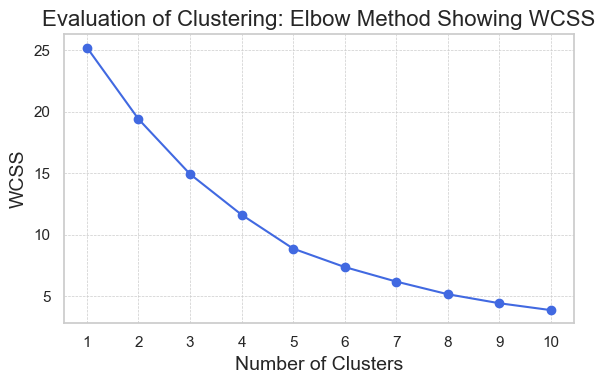

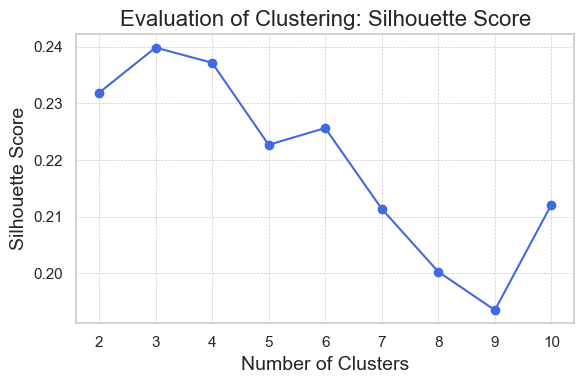

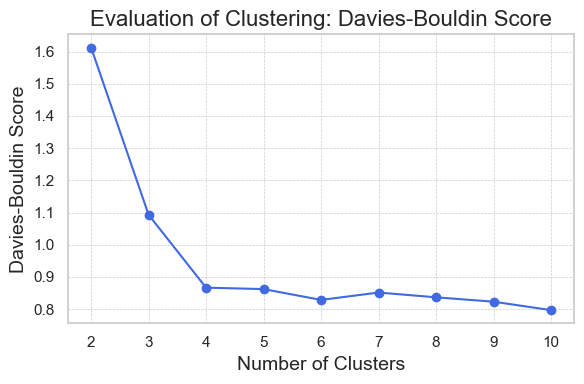

In [14]:
wcss, silhouette_scores, db_scores = evaluate_clustering(data_normalized, 10, random_states)
optimal_clusters_silhouette = find_optimal_silhouette(silhouette_scores)
optimal_clusters_davies_bouldin = find_optimal_davies_bouldin(db_scores)

print(f"Optimal number of clusters by Silhouette Method: {optimal_clusters_silhouette}")
print(
    f"Optimal number of clusters by Davies-Bouldin Method: {optimal_clusters_davies_bouldin}"
)
plot_metric(wcss, "Elbow Method Showing WCSS", ylabel="WCSS")
plot_metric(silhouette_scores, "Silhouette Score", start=2, ylabel="Silhouette Score")
plot_metric(db_scores, "Davies-Bouldin Score", start=2, ylabel="Davies-Bouldin Score")

In [15]:
n_optimal_clusters = 3

cluster_dfs, centroids, labels = fit_kmeans_and_return_cluster_dfs(
    data_normalized, n_optimal_clusters, random_state=123
)

for i in range(len(cluster_dfs)):
    print(f"Cluster {i + 1} includes dataset: {cluster_dfs[i].index.tolist()}")

Cluster 1 includes dataset: ['amazon_mi', 'amazon_cds', 'douban_music', 'yelp', 'goodreads', 'food', 'amazon_tv', 'gowalla', 'tafeng', 'amazon_finefoods', 'brightkite', 'retail', 'mts_library', 'epinions', 'douban_books', 'sber_zvuk', 'sber_smm']
Cluster 2 includes dataset: ['movielens_1m', 'rekko', 'dianping', 'reddit', 'movielens_20m', 'beeradvocate', 'netflix', 'kuairec_full', 'movielens_10m', 'douban_movies', 'ratebeer', 'foursquare']
Cluster 3 includes dataset: ['kuairec_small']


### Scaled DATA ###

Optimal number of clusters by Silhouette Method: 2
Optimal number of clusters by Davies-Bouldin Method: 2


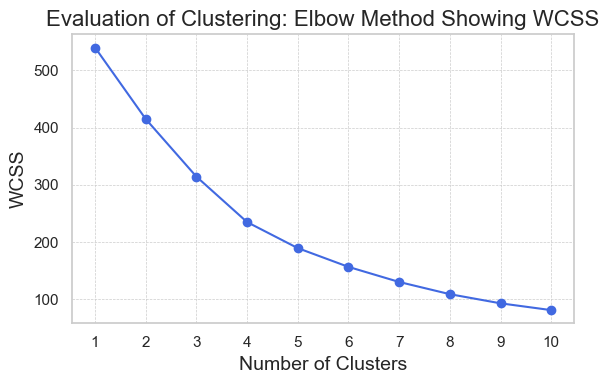

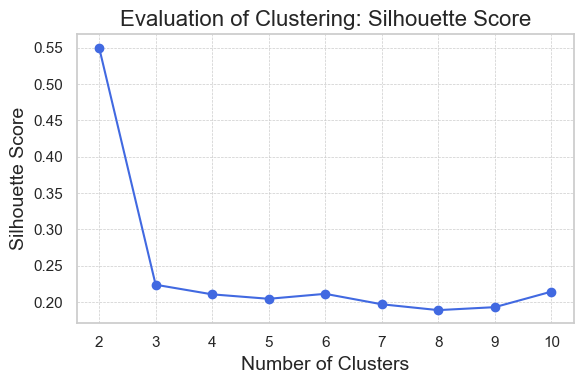

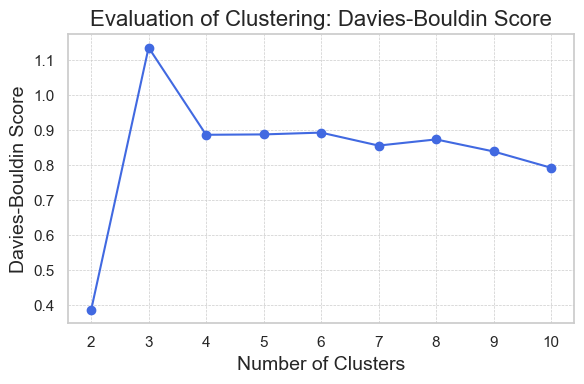

In [16]:
wcss, silhouette_scores, db_scores = evaluate_clustering(data_scaled, 10, random_states)
optimal_clusters_silhouette = find_optimal_silhouette(silhouette_scores)
optimal_clusters_davies_bouldin = find_optimal_davies_bouldin(db_scores)

print(f"Optimal number of clusters by Silhouette Method: {optimal_clusters_silhouette}")
print(
    f"Optimal number of clusters by Davies-Bouldin Method: {optimal_clusters_davies_bouldin}"
)
plot_metric(wcss, "Elbow Method Showing WCSS", ylabel="WCSS")
plot_metric(silhouette_scores, "Silhouette Score", start=2, ylabel="Silhouette Score")
plot_metric(db_scores, "Davies-Bouldin Score", start=2, ylabel="Davies-Bouldin Score")

### SELECTING SCALED DATA WITH 2 OPTIMAL NUMBER OF CLUSTERS ###

In [17]:
n_optimal_clusters = 2

cluster_dfs, centroids, labels = fit_kmeans_and_return_cluster_dfs(
    data_normalized, n_optimal_clusters,random_state=12345
)

for i in range(len(cluster_dfs)):
    print(f"Cluster {i + 1} includes dataset: {cluster_dfs[i].index.tolist()}")

Cluster 1 includes dataset: ['movielens_1m', 'rekko', 'dianping', 'reddit', 'movielens_20m', 'beeradvocate', 'netflix', 'kuairec_full', 'movielens_10m', 'kuairec_small', 'douban_movies', 'ratebeer', 'foursquare']
Cluster 2 includes dataset: ['amazon_mi', 'amazon_cds', 'douban_music', 'yelp', 'goodreads', 'food', 'amazon_tv', 'gowalla', 'tafeng', 'amazon_finefoods', 'brightkite', 'retail', 'mts_library', 'epinions', 'douban_books', 'sber_zvuk', 'sber_smm']


/home/nikita/miniconda3/envs/recsys/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


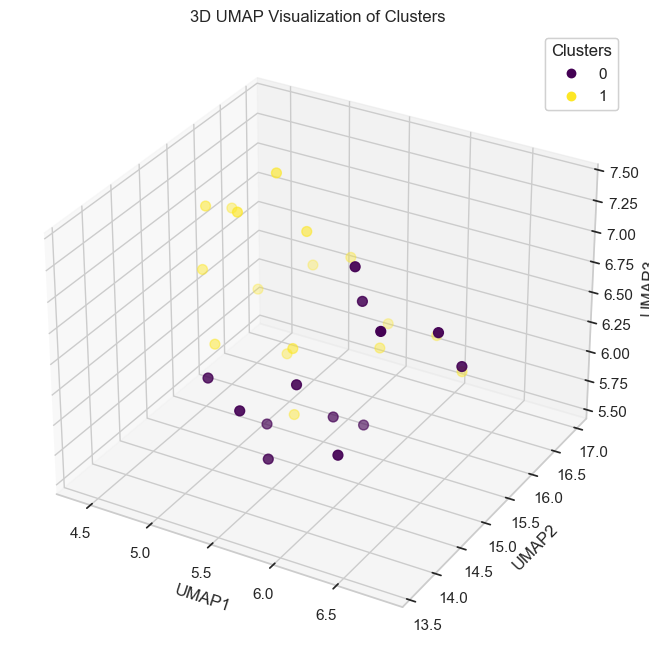

In [18]:
# Fit UMAP
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(data_scaled)

# Convert the embedding into a DataFrame for easier plotting
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2", "UMAP3"])
embedding_df["Cluster"] = labels

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    embedding_df["UMAP1"],
    embedding_df["UMAP2"],
    embedding_df["UMAP3"],
    c=embedding_df["Cluster"],
    cmap="viridis",
    s=50,
)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_title("3D UMAP Visualization of Clusters")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
plt.show()

/home/nikita/miniconda3/envs/recsys/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Optimal number of clusters by Silhouette Method: 4
Optimal number of clusters by Davies-Bouldin Method: 4


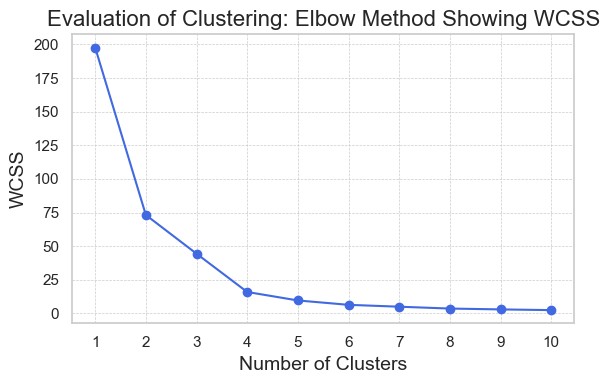

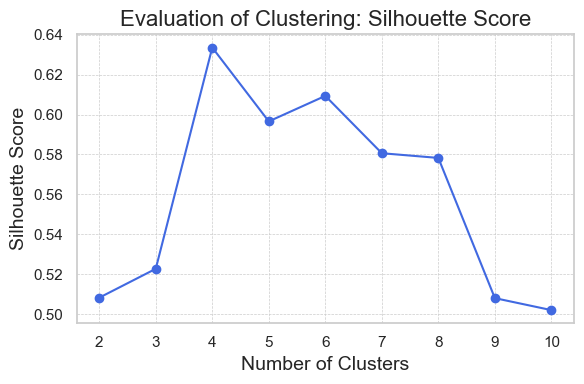

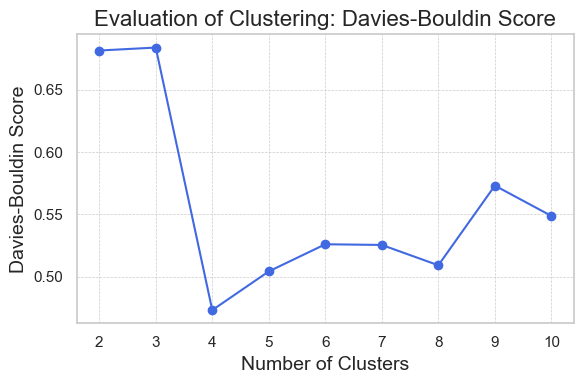

In [19]:
# Dimension reduction using UMAP
umap_reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, random_state=42)
umap_results = umap_reducer.fit_transform(data_scaled)

wcss, silhouette_scores, db_scores = evaluate_clustering(umap_results, 10, random_states)
optimal_clusters_silhouette = find_optimal_silhouette(silhouette_scores)
optimal_clusters_davies_bouldin = find_optimal_davies_bouldin(db_scores)

print(f"Optimal number of clusters by Silhouette Method: {optimal_clusters_silhouette}")
print(
    f"Optimal number of clusters by Davies-Bouldin Method: {optimal_clusters_davies_bouldin}"
)
plot_metric(wcss, "Elbow Method Showing WCSS", ylabel="WCSS")
plot_metric(silhouette_scores, "Silhouette Score", start=2, ylabel="Silhouette Score")
plot_metric(db_scores, "Davies-Bouldin Score", start=2, ylabel="Davies-Bouldin Score")

In [31]:
data

,Nu,Ni,Nr,SpaceSize,Shape,Density,Rpu,Rpi,Ginii,Giniu,APB,StPB,SkPB,KuPB,LTavg,LTstd,LTsk,LTku
amazon_mi,9785,28921,189312,282991985,0.338335,0.000669,19.347164,6.545832,0.321962,0.566611,0.001109,0.000562,3.289954,17.372120,0.233041,0.157824,0.853704,1.104812
movielens_1m,5970,3121,569029,18632370,1.912848,0.030540,95.314740,182.322653,0.661529,0.506730,0.127364,0.037673,0.583107,0.404406,0.166169,0.114944,1.084686,1.757140
rekko,19362,4326,219335,83760012,4.475728,0.002619,11.328117,50.701572,0.721498,0.374776,0.024555,0.014047,0.911885,0.891251,0.166057,0.169179,1.184794,1.597647
amazon_cds,69394,116073,1178506,8054769762,0.597848,0.000146,16.982823,10.153145,0.488385,0.517409,0.001067,0.001119,2.485566,8.821879,0.217023,0.160289,0.875017,1.056670
douban_music,1060,4926,48662,5221560,0.215185,0.009319,45.907547,9.878603,0.335240,0.605873,0.016903,0.005927,1.381948,3.834639,0.187005,0.124116,0.877214,2.382531
yelp,179205,108337,2474475,19414532085,1.654144,0.000127,13.808069,22.840535,0.682083,0.473308,0.000968,0.000890,2.316045,7.325097,0.202201,0.191842,1.069386,1.000831
dianping,60516,9217,1252088,557775972,6.565694,0.002245,20.690198,135.845503,0.675344,0.483200,0.011184,0.004931,0.849525,1.617943,0.190653,0.161250,1.220314,2.279573
goodreads,81118,107389,2134696,8711180902,0.755366,0.000245,26.315935,19.878163,0.613750,0.555535,0.003626,0.003416,1.554350,2.894831,0.190420,0.185754,1.236873,1.550453
food,16390,46681,521934,765101590,0.351106,0.000682,31.844661,11.180866,0.489234,0.673942,0.004382,0.003459,1.933928,5.815760,0.166098,0.142370,1.044542,1.575516
amazon_tv,24856,65430,1242413,1626328080,0.379887,0.000764,49.984430,18.988430,0.396453,0.577305,0.002648,0.001720,1.818189,4.788484,0.212169,0.113833,1.053133,2.233765


/home/nikita/miniconda3/envs/recsys/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/nikita/miniconda3/envs/recsys/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


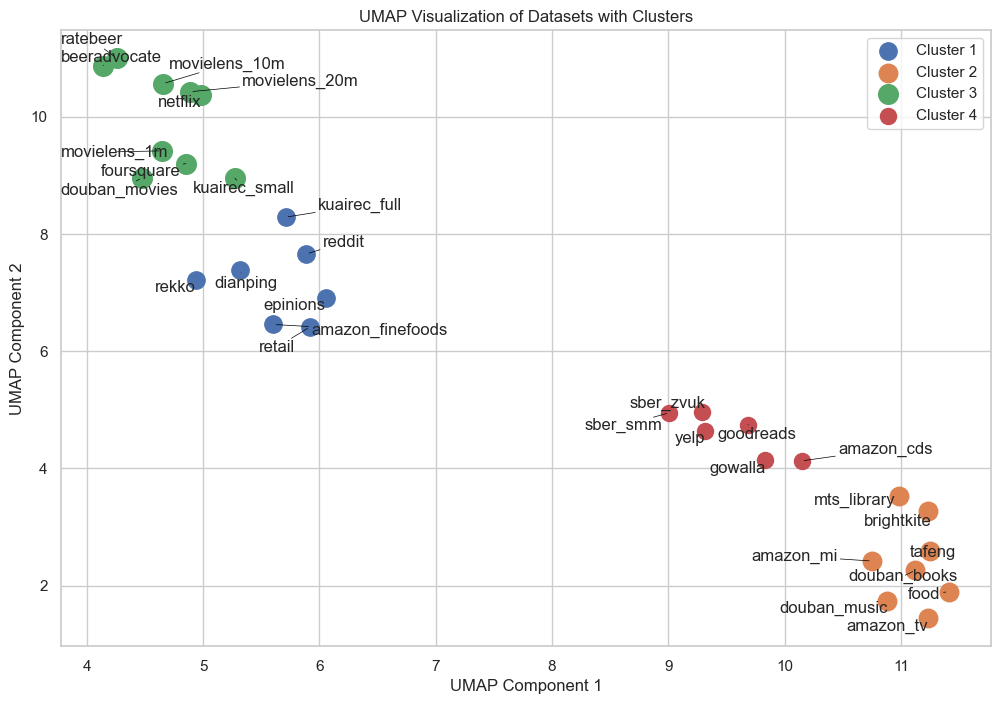

In [44]:
umap_reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, random_state=213)
umap_results = umap_reducer.fit_transform(data_scaled)

# Clustering using KMeans
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=10)
kmeans_labels = kmeans.fit_predict(umap_results)

# Get the size of each cluster
cluster_sizes = np.bincount(kmeans_labels)

# Calculate the scaling factor for circle sizes
max_circle_size = 200
scaling_factor = max_circle_size / np.max(cluster_sizes)

# Plot UMAP with cluster colors and circle sizes
plt.figure(figsize=(12, 8))
for cluster_num in range(n_clusters):
    cluster_points = umap_results[kmeans_labels == cluster_num]
    cluster_size = cluster_sizes[cluster_num]
    circle_size = cluster_size * scaling_factor
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        s=circle_size,
        label=f"Cluster {cluster_num + 1}",
    )

# Add labels using dataset names
texts = []
for i, dataset in enumerate(data.index):
    texts.append(plt.text(umap_results[i, 0], umap_results[i, 1], dataset))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

plt.title("UMAP Visualization of Datasets with Clusters")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend()
plt.show()

In [45]:
clustered_datasets = {}
for cluster_num in range(n_clusters):
    indexes = np.where(kmeans_labels == cluster_num)[0]
    clustered_datasets[f"Cluster {cluster_num + 1}"] = data.index[indexes].tolist()
    
for cluster, datasets in clustered_datasets.items():
    print(f"{cluster}:")
    print(f"number of datasets: {len(datasets)}")
    print(datasets)

Cluster 1:
number of datasets: 7
['rekko', 'dianping', 'reddit', 'amazon_finefoods', 'kuairec_full', 'retail', 'epinions']
Cluster 2:
number of datasets: 8
['amazon_mi', 'douban_music', 'food', 'amazon_tv', 'tafeng', 'brightkite', 'mts_library', 'douban_books']
Cluster 3:
number of datasets: 9
['movielens_1m', 'movielens_20m', 'beeradvocate', 'netflix', 'movielens_10m', 'kuairec_small', 'douban_movies', 'ratebeer', 'foursquare']
Cluster 4:
number of datasets: 6
['amazon_cds', 'yelp', 'goodreads', 'gowalla', 'sber_zvuk', 'sber_smm']


In [83]:
clustered_datasets = []
for cluster_num in [0, 2, 1, 3]:
    indexes = np.where(kmeans_labels == cluster_num)[0]
    clustered_datasets.append(data.index[indexes].tolist())
cluster_mapping = {}
for i, cluster in enumerate(clustered_datasets):
    for dataset in cluster:
        cluster_mapping[dataset] = i + 1

In [85]:
data_scaled_clustered = data_scaled.copy()
data_scaled_clustered["cluster"] = data_scaled_clustered.index.map(cluster_mapping)
data_scaled_clustered

,Nu,Ni,Nr,SpaceSize,Shape,Density,Rpu,Rpi,Ginii,Giniu,APB,StPB,SkPB,KuPB,LTavg,LTstd,LTsk,LTku,cluster
amazon_mi,-0.536861,-0.254327,-0.431839,-0.503627,-0.454428,-0.264160,-0.331504,-0.429552,-1.555244,0.544012,-0.457604,-0.926590,1.970834,3.345128,1.225600,0.130547,-0.500380,-0.601785,3
movielens_1m,-0.579975,-0.781189,-0.400999,-0.540523,-0.118521,-0.061800,-0.173797,-0.139479,0.466930,0.122071,0.297629,1.307247,-0.734122,-0.909805,-0.764558,-0.761361,0.036872,0.052960,2
rekko,-0.428630,-0.756581,-0.429400,-0.531433,0.428245,-0.250952,-0.348152,-0.356684,0.824056,-0.807709,-0.317353,-0.114875,-0.405574,-0.787721,-0.767885,0.366740,0.269718,-0.107124,1
amazon_cds,0.136790,1.525403,-0.351499,0.581058,-0.399064,-0.267700,-0.336413,-0.423599,-0.564167,0.197318,-0.457857,-0.893058,1.167008,1.201014,0.748889,0.181838,-0.450807,-0.650106,4
douban_music,-0.635463,-0.744329,-0.443262,-0.542394,-0.480701,-0.205557,-0.276365,-0.424052,-1.476176,0.820659,-0.363126,-0.603625,0.064161,-0.049618,-0.144473,-0.570583,-0.445697,0.680668,3
yelp,1.377782,1.367426,-0.246244,2.166508,-0.173713,-0.267828,-0.343003,-0.402661,0.589335,-0.113429,-0.458452,-0.906834,0.997605,0.825672,0.307764,0.838138,0.001285,-0.706152,4
dianping,0.036458,-0.656702,-0.345523,-0.465276,0.874119,-0.253484,-0.328716,-0.216177,0.549203,-0.043725,-0.397340,-0.663596,-0.467890,-0.605491,-0.035895,0.201824,0.352338,0.577328,1
goodreads,0.269285,1.348067,-0.273840,0.672672,-0.365459,-0.267031,-0.317037,-0.407550,0.182398,0.465966,-0.442549,-0.754785,0.236443,-0.285290,-0.042830,0.711509,0.390852,-0.154493,4
food,-0.462217,0.108350,-0.404824,-0.436340,-0.451704,-0.264070,-0.305560,-0.421903,-0.559116,1.300285,-0.438026,-0.752202,0.615756,0.447181,-0.766686,-0.190884,-0.056501,-0.129337,3
amazon_tv,-0.366541,0.491223,-0.346309,-0.316141,-0.445564,-0.263516,-0.267902,-0.409018,-1.111641,0.619359,-0.448398,-0.856906,0.500097,0.189574,0.604444,-0.784483,-0.036519,0.531350,3


In [86]:
data_scaled_clustered.columns[:-1]

Index(['Nu', 'Ni', 'Nr', 'SpaceSize', 'Shape', 'Density', 'Rpu', 'Rpi',
       'Ginii', 'Giniu', 'APB', 'StPB', 'SkPB', 'KuPB', 'LTavg', 'LTstd',
       'LTsk', 'LTku'],
      dtype='object')

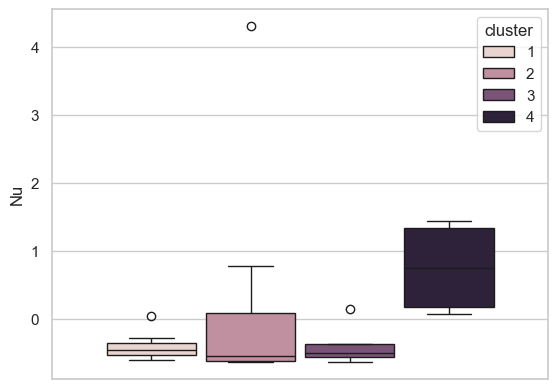

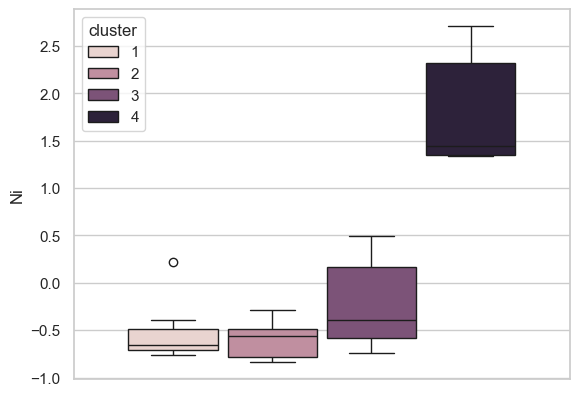

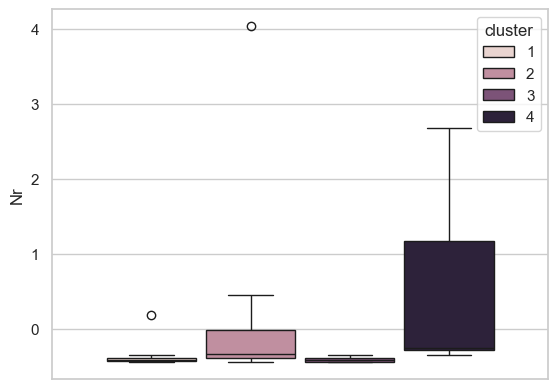

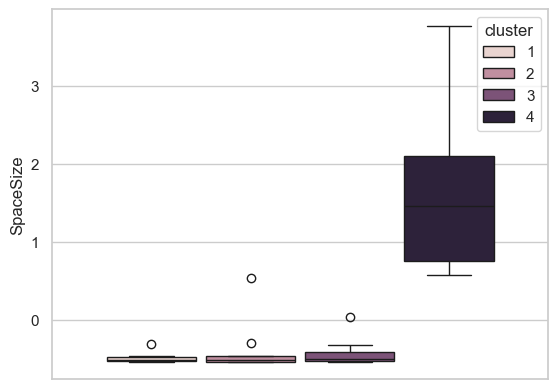

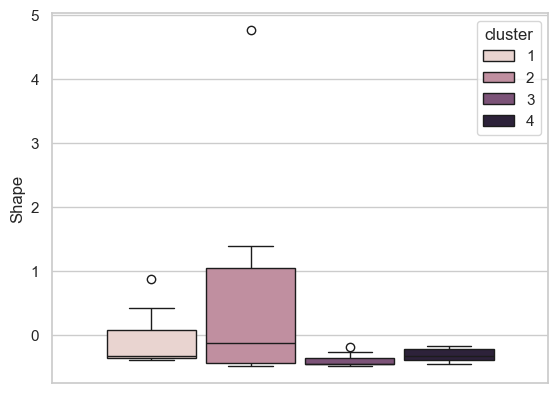

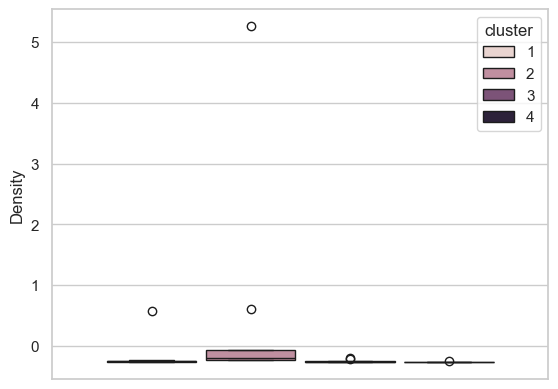

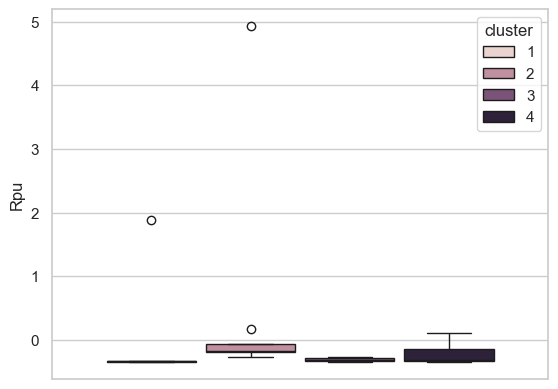

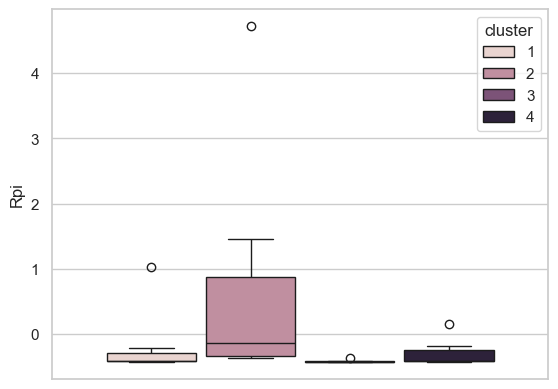

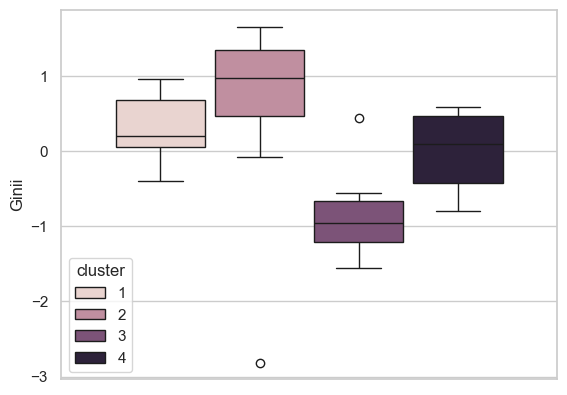

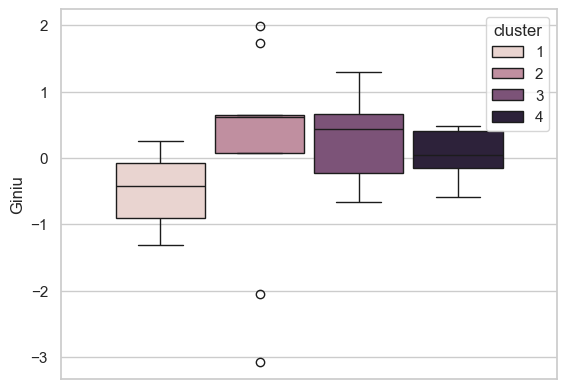

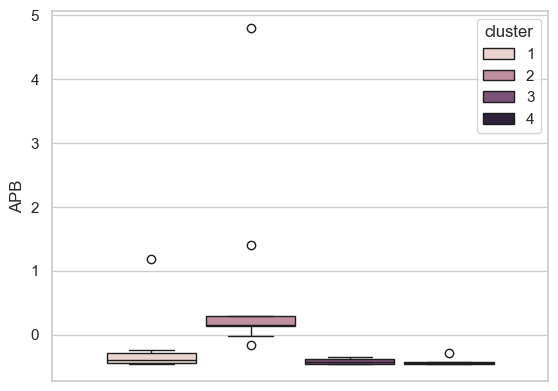

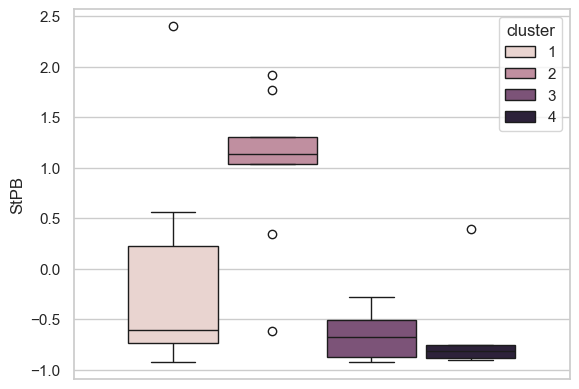

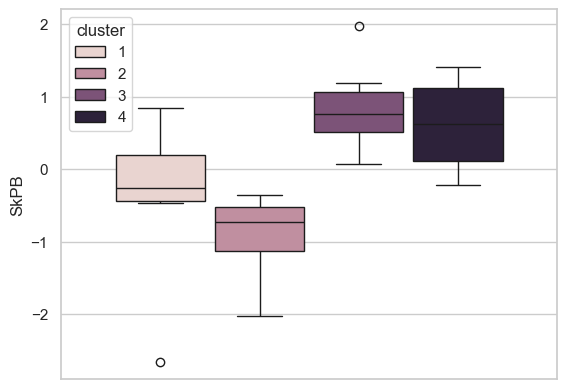

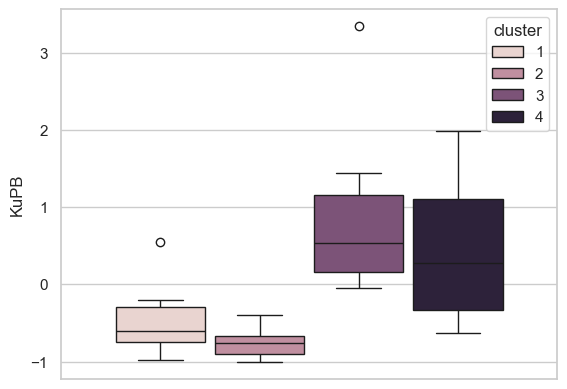

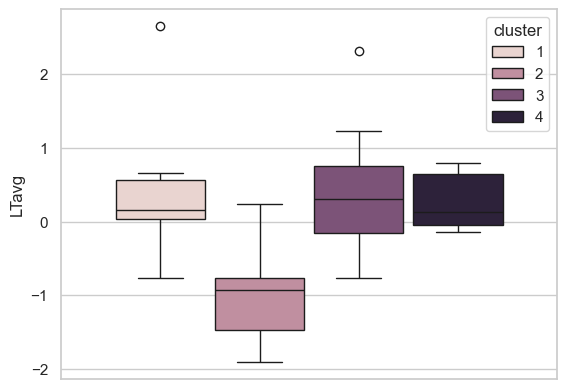

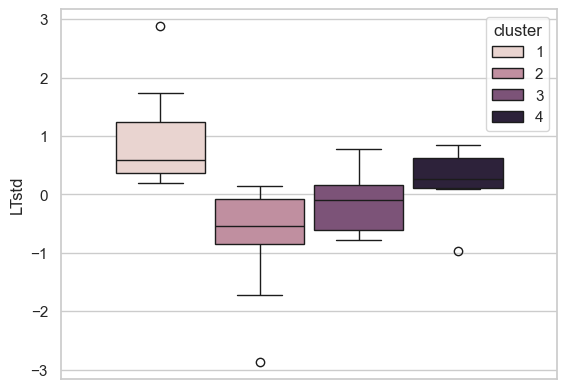

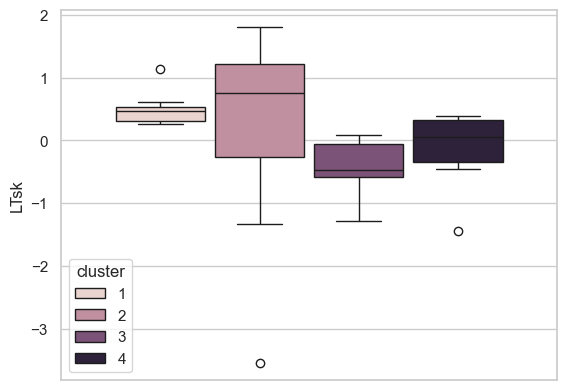

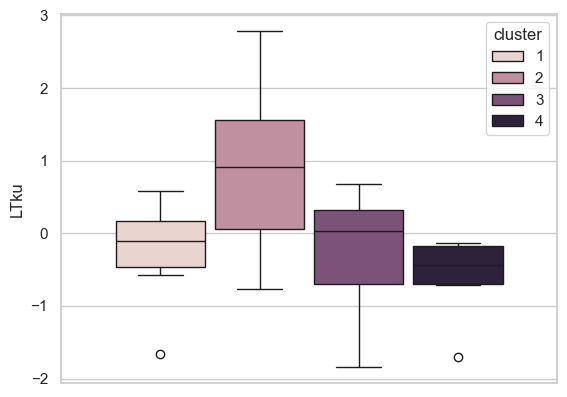

In [87]:
for metric in data_scaled_clustered.columns[:-1]:
    sns.boxplot(y=metric, hue="cluster", data=data_scaled_clustered, gap=.1)
    plt.show()